In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers
import numpy as np
import tensorflow as tf
import gymnasium as gym
import scipy.signal
import torch
# import os
# os.chdir('/content/MultiTradingEnv/MultiTrading/RL-Final-Env')
# print(os.getcwd())
from Env import MultiTradingEnv,State,Action
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
tf.experimental.numpy.experimental_enable_numpy_behavior()

2024-05-01 13:42:28.878901: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 13:42:30.412357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
stocks=['63MOONS.csv','NHPC.csv','BIOCON.csv','BHEL.csv']
stocks=['BSOFT.csv','BIRLACORPN.csv','BLUECOAST.csv','BLUEDART.csv']
stocks=['btc_30m.csv','ETH_1H.csv']

dataframes=[]
# stocks=['63MOONS.csv']
path='/home/siddharth/Desktop/MultiTrading/Datasets/SCRIP/'
path='/home/siddharth/Desktop/MultiTrading/'
timesteps=1000
for name in stocks:
    df=pd.read_csv(path+name)
    df=df[:timesteps]
    df=df[['Open','Close','High','Low','Volume']]
    df.reset_index(inplace=True,drop=True)
    dataframes.append(df)


In [3]:
import ta

def preprocess(data):
    long_sma_window = 50
    short_sma_window = 20
    data['feature_Long_SMA'] = data['Close'].rolling(window=long_sma_window, min_periods=1).mean()
    data['feature_Short_SMA'] = data['Close'].rolling(window=short_sma_window, min_periods=1).mean()
    data['feature_RSI'] = ta.momentum.rsi(close=data['Close'], window=14)
    data["feature_Close"] = data["Close"].pct_change()
    data["feature_Open"] = data["Open"]/data["Close"]
    data["feature_High"] = data["High"]/data["Close"]
    data["feature_Low"] = data["Low"]/data["Close"]
    data['feature_MACD'] = ta.trend.macd(data["Close"])
    data['feature_CCI'] = ta.trend.cci(data["High"], data["Low"], data["Close"], window=20)
    data['feature_BB_upper'], data['feature_BB_middle'], data['feature_BB_lower'] = ta.volatility.bollinger_hband(data["Close"]), ta.volatility.bollinger_mavg(data["Close"]), ta.volatility.bollinger_lband(data["Close"])
    data['feature_Slowk']= ta.momentum.stoch(data["High"], data["Low"], data["Close"])
    data['feature_ATR'] = ta.volatility.average_true_range(data["High"], data["Low"], data["Close"], window=14)
    data.dropna(inplace=True)
    data.reset_index(inplace=True, drop=True)


In [4]:
norm_dataframes=[]
for i in range(len(dataframes)):
    df=dataframes[i]
    preprocess(df)
    dataframes[i]=df
    df = (df - df.min()) / (df.max() - df.min())
    norm_dataframes.append(df)
for i in norm_dataframes:
    print(i)

         Open     Close      High       Low    Volume  feature_Long_SMA  \
0    0.503980  0.507134  0.487722  0.509385  0.027546          0.498033   
1    0.504379  0.483084  0.481839  0.471703  0.066521          0.495188   
2    0.483084  0.487991  0.469377  0.484931  0.037607          0.492766   
3    0.485861  0.476906  0.487650  0.463506  0.091656          0.490032   
4    0.476907  0.511934  0.487650  0.473867  0.069066          0.488945   
..        ...       ...       ...       ...       ...               ...   
970  0.282000  0.295707  0.266613  0.285289  0.177313          0.284151   
971  0.295705  0.283530  0.256890  0.282470  0.123002          0.278962   
972  0.283530  0.255563  0.247195  0.258890  0.168094          0.273470   
973  0.256788  0.243250  0.219827  0.245165  0.149563          0.268089   
974  0.241432  0.255079  0.221130  0.240799  0.243492          0.263284   

     feature_Short_SMA  feature_RSI  feature_Close  feature_Open  \
0             0.523913     0.33

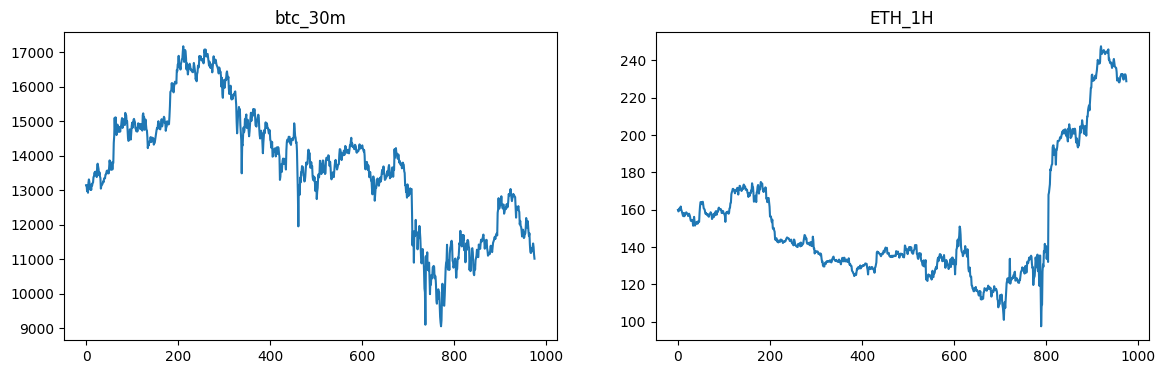

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def create_subplots(n,df=dataframes,st=stocks):
    fig, axes = plt.subplots(1, n, figsize=(7*n, 2*n))
    for i in range(n):
        data = df[i]['Open']
        axes[i].plot(data)
        axes[i].set_title(st[i][:-4])
    plt.show()
n = len(dataframes)
create_subplots(n,df=dataframes,st=stocks)

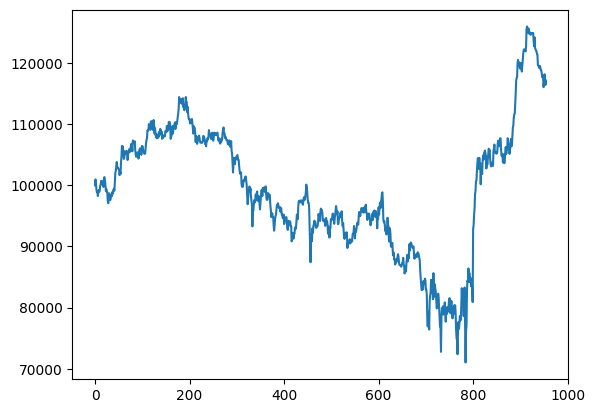

In [66]:
num_stocks=2
tmp=np.zeros(shape=(len(dataframes[0])))
cnt=0
wts=np.ones(num_stocks)/num_stocks
for i in dataframes:
    num=(100000*wts[cnt])/np.array(i['Open'][0])
    ar=np.array(i['Open'])*num
    tmp+=ar
    cnt+=1
tmp=tmp[5:-15]
tmp/=tmp[0]
tmp*=100000
plt.plot(tmp)

In [6]:

import itertools
num_stocks=len(dataframes)
boxes=2*num_stocks
rng = list(range(boxes + 1)) * num_stocks
wt_combs=[]
lol=set(i for i in itertools.permutations(rng, num_stocks) if sum(i) == boxes)
for i in lol:
    wt_combs.append(i)
wt_combs=np.array(wt_combs)
wt_combs_norm=wt_combs/boxes
print((wt_combs_norm))


[[1.   0.  ]
 [0.   1.  ]
 [0.75 0.25]
 [0.5  0.5 ]
 [0.25 0.75]]


In [8]:
from Env import MultiTradingEnv;
LOOKBACK=1
step=0.25
positions=np.arange(0,1,step)
positions=np.append(positions,1)
print(positions)
env = MultiTradingEnv(dataframes_array=dataframes,
                      norm_dataframes=norm_dataframes,
                       total_timesteps=len(dataframes[0])-LOOKBACK-1,
                       initial_cap=100000.0,
                       features=dataframes[0].columns,
                       lookback=LOOKBACK,
                       positions=positions,
                       wt_combs=wt_combs_norm,
                       )


[0.   0.25 0.5  0.75 1.  ]


In [9]:
# Hyperparameters of the PPO algorithm
steps_per_epoch = 100
epochs = 30
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.97
target_kl = 0.01
hidden_sizes = (64, 64)

# True if you want to render the environment
render = False


In [10]:
def discounted_cumulative_sums(x, discount):
    ls=[]
    for i in range(1):
        ls.append(scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1])
    # return np.array(ls)
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(shape=(size,env.num_stocks),dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros((size,env.num_stocks), dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = np.array(action)
        # print(self.action_buffer,action)
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1
        # print(self.pointer)


    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


def mlp(x, sizes, activation=keras.activations.tanh, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)


def logprobabilities(logits, a):
    
    # print(logits.shape,a.shape)
    # logits=logits.reshape(-1,env.num_stocks,len(env.positions))
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = keras.ops.log_softmax(logits)
    # print(logprobabilities_all.shape)
    logprobability = keras.ops.sum(
        keras.ops.one_hot(a, len(env.positions)) * logprobabilities_all, axis=1
    )
    # print(logprobability.shape)
    return logprobability
def logprobabilitiesall(logits, a):
    
    # print(logits.shape,a.shape)
    logits=logits.reshape(-1,env.num_stocks,len(env.positions))
    # print(logits.shape)
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = keras.ops.log_softmax(logits,axis=-1)
    # print(logprobabilities_all.shape)
    # print(logprobabilities_all.shape)
    logprobability = keras.ops.sum(
        keras.ops.one_hot(a, len(env.positions)) * logprobabilities_all, axis=2
    )
    # print(logprobability.shape)
    return logprobability

seed_generator = keras.random.SeedGenerator(1337)


# Sample action from actor
def sample_action(observation):
    logits = actor(observation)
    # print(logits.shape)
    logits=logits.reshape(env.num_stocks,-1)
    action = keras.ops.squeeze(
        keras.random.categorical(logits, 1, seed=seed_generator), axis=1
    )
    
    return logits, action


# Train the policy by maxizing the PPO-Clip objective
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):
    # print(actor(observation_buffer).shape,action_buffer.shape)
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = keras.ops.exp(
            logprobabilitiesall(actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        # print(ratio)
        min_advantage = keras.ops.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -keras.ops.mean(
            keras.ops.minimum(ratio * np.array([advantage_buffer for i in range(env.num_stocks)]).reshape(-1,env.num_stocks), np.array([min_advantage for i in range(env.num_stocks)]).reshape(-1,env.num_stocks))
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = keras.ops.mean(
        logprobability_buffer
        - logprobabilitiesall(actor(observation_buffer), action_buffer)
    )
    kl = keras.ops.sum(kl)
    return kl


# Train the value function by regression on mean-squared error
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = keras.ops.mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))


2024-05-01 13:43:32.028630: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [71]:
num_actions = len(env.positions)
state = env.reset()
n_observations = len(state.features.flatten())
# Initialize the buffer
buffer = Buffer(n_observations, 100000)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(n_observations,), dtype="float32")
logits = mlp(observation_input, list(hidden_sizes) + [env.num_stocks*num_actions])
actor = keras.Model(inputs=observation_input, outputs=logits)
value = keras.ops.squeeze(mlp(observation_input, list(hidden_sizes) + [1]), axis=1)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)


# Initialize the observation, episode return and episode length
observation = env.reset()
episode_return= 0

In [11]:
for epoch in range(epochs):
    observation = env.reset()
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0
    episode_return=0
    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        # Get the logits, action, and take one step in the environment'
        observation = observation.features.reshape(1, -1)
        # print(observation)
        logits, action = sample_action(observation)
        # print(logits,action)
        observation_new, reward, done = env.step(action,4)
        # print(reward)
        episode_return += reward

        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)
        # print(logprobability_t)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation, action, reward, value_t, logprobability_t)

        # Update the observation
        observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        # print(done,t)
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.features.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            num_episodes += 1
            print(f'Epoch{epoch},{episode_return}{env.net_worth}')

            observation= env.reset()
            episode_return, episode_length = 0, 0

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()
    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer, return_buffer)



NameError: name 'actor' is not defined